<a href="https://colab.research.google.com/github/Nemoy2897/Neural-Style-Transfer-/blob/master/Neural_style_transfer_with_multiple_loaded_networks(No_training_involved).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b

%matplotlib inline

In [0]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model

Using TensorFlow backend.


In [0]:
import tensorflow.contrib.keras.api.keras.backend as K

In [0]:
ls

sample_data/


In [0]:
from google.colab import files

uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]))


Saving pink_floyd.jpg to pink_floyd.jpg
Saving psych.jpg to psych.jpg


### **1. PreProcess Input Images (Normalize pixel values and reshape the image)**

---



In [0]:
img_h=720
img_w=1280

In [0]:
def preprocess(img_path):
  img = image.load_img(img_path)
  img = image.img_to_array(img)
  img = imresize(img,(img_h,img_w,3))
  img = img.astype('float64')
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  
  return img

*imagename_pp = preprocessed image we'll use a bunch of combinations i guess or maybe not*



In [0]:
# tiger_pp = preprocess('tiger.jpg')
# manon_pp = preprocess('manonhike.jpg')
# vangogh_pp = preprocess('van_gogh_mine1.jpg')
# joanmiro_pp =preprocess('joan-miro.jpg')
# selfpotr_pp = preprocess('self-portraits-van-gogh.jpg')

pinkfloyd_pp = preprocess('pink_floyd.jpg')
psych_pp = preprocess('psych.jpg')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


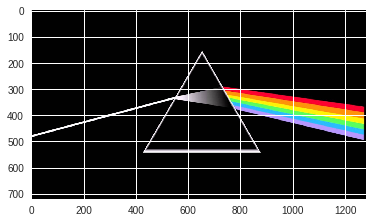

In [0]:
plt.imshow(image.load_img('pinkfloyd_prism.jpg'))

In [0]:
content_img = K.variable(pinkfloyd_pp)
style_img = K.variable(psych_pp)
gen_img = K.placeholder(shape=(1,img_h,img_w,3))
input_tensor = K.concatenate([content_img,style_img,gen_img],axis=0)

In [0]:

model = VGG19(weights = 'imagenet' , include_top = False, input_shape = [720,1280,3], input_tensor = input_tensor)
print('Model loaded')

output_dict = dict([(layer.name, layer.output) for layer in model.layers])

80142336/80134624 [==============================] - 1s 0us/step
Model loaded


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 720, 1280, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 720, 1280, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 720, 1280, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 360, 640, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 360, 640, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 360, 640, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 180, 320, 128)     0         
__________

In [0]:
def compute_content_cost(a_C_unrolled,a_G_unrolled):
  J_content = K.sum(K.square(a_C_unrolled - a_G_unrolled))/(4*3*img_h*img_w)
  
  
  return J_content

In [0]:
def gram_matrix(A):
  assert K.ndim(A) == 3
  features = K.batch_flatten(K.permute_dimensions(A,(2,0,1)))
  return K.dot(features,K.transpose(features))

In [0]:
def compute_layer_style_cost(a_S,a_G):
  assert K.ndim(a_S) == 3
  assert K.ndim(a_G) == 3
  
  
  GG = gram_matrix(a_G)
  GS = gram_matrix(a_S)
  n_c=3
  
  return K.sum(K.square(GG - GS))/(4*(n_c*img_h*img_w)**2)
  

In [0]:
STYLE_LAYERS=[
    ('block1_conv2', 0.1),
    ('block2_conv2', 0.1),
    ('block3_pool',0.1),
    ('block4_conv3',0.1),
    ('block4_pool',0.1)
    
]



In [0]:
def compute_style_cost(model, STYLE_LAYERS):
  
  J_style = 0
  
  for layer_name, coeff in STYLE_LAYERS:
    layer_features = output_dict[layer_name]
    
    a_S = layer_features[1, :, :, :]
    
    a_G = layer_features[2, :, :, :]
    
    J_style_layer = compute_layer_style_cost(a_S,a_G)
    
    J_style += coeff*J_style_layer
  return J_style

In [0]:
def total_variance_loss(x):
  assert K.ndim(x) == 4
  a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
  b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
  
  return K.sum(K.pow(a+b,1.25))/(12*img_h*img_w)
  

In [0]:
CONTENT_WEIGHT = 40
STYLE_WEIGHT = 100
VAR_WEIGHT = 1.0

loss = 0 
layer_features = output_dict['block4_conv2']

content_img_features = layer_features[0, :, :, :]
gen_img_features = layer_features[2, :, :, :]

loss += CONTENT_WEIGHT*compute_content_cost(content_img_features, gen_img_features)

loss += STYLE_WEIGHT*compute_style_cost(model, STYLE_LAYERS)

loss += VAR_WEIGHT*total_variance_loss(gen_img)


In [0]:
grads = K.gradients(loss, gen_img)

outputs = [loss]

if isinstance(grads, (list,tuple)):
  outputs += grads
else:
  outputs.append(grads)
  
f_output = K.function([gen_img],outputs)


def eval_loss_and_grads(x):
  x= x.reshape((1, img_h, img_w, 3))
  outs = f_output([x])
  loss_value = outs[0]
  
  if len(outs[1:]) == 1:
    grad_values = outs[1].flatten().astype('float64')
  
  else:
    grad_values = np.array(outs[1:]).flatten().astype('float64')
    
  return loss_value, grad_values


class Evaluator( object ):
  def __init__(self):
    self.loss_value = None
    self.grads_value = None
    
  def loss(self, x):
    assert self.loss_value is None
    loss_value, grad_value = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grads_value = grad_value
    
    return self.loss_value
  
  def grads(self,x):
    assert self.loss_value is not None
    grads_value = np.copy(self.grads_value)
    self.loss_value = None
    self.grads_value = None
    return grads_value

In [0]:
def deprocess_image(img):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_h, img_w, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [0]:
def generate_noise_image(image, noise_ratio):
  """
  generates a noise image by adding random noise to the content image
  
  """
  noise_image = np.random.uniform(-20,20,(1,224,224,3)).astype('float32')
  
  input_image = noise_image*noise_ratio + image*(1-noise_ratio)
  
  return input_image

In [0]:
import time

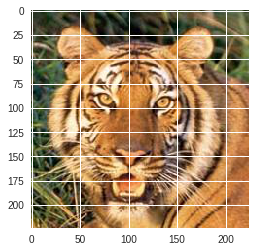

## THIS PIECE of Code runs everything for us !?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 360151351296.0
     Image saved. Time: 198.1897439956665
Step 1
    loss: 997052055552.0
     Image saved. Time: 220.68458318710327


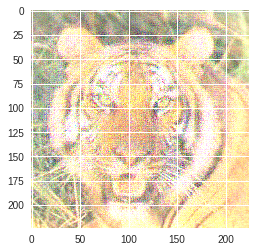

In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('tiger.jpg')

for i in range(2):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=50)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))


**Following changes made to the below model :**



1.   changed content layer to res2c_branch2b from res5c_branch2a
2.   changed tv ratio to 5 from 1
3. content loss from 60 to 40
4. style loss from 40 to 60
5. maxiter form 50 to 100



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 412696313856.0
     Image saved. Time: 390.6115343570709
Step 1
    loss: 453459017728.0
     Image saved. Time: 399.5088403224945


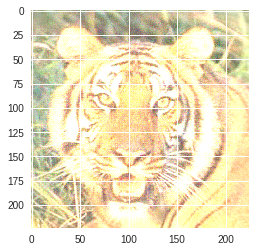

In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('tiger.jpg')

for i in range(2):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=100)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 22267874508800.0
     Image saved. Time: 204.76779794692993
Step 1
    loss: 12998833864704.0
     Image saved. Time: 195.86543464660645
Step 2
    loss: 10030299480064.0
     Image saved. Time: 198.2406837940216


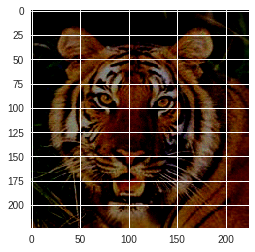

In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('tiger.jpg')

for i in range(3):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=50)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 219177583378432.0
     Image saved. Time: 230.4833061695099
Step 1
    loss: 101090108375040.0
     Image saved. Time: 199.28430461883545
Step 2
    loss: 69745156030464.0
     Image saved. Time: 201.9193720817566


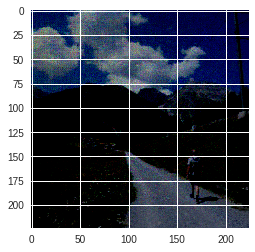

In [0]:
#  using a different image for content to see what difference does it make?
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('manonhike.jpg')

for i in range(3):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=50)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

**USING VGG19 for this iteration let's see where this goes, using the same parameters as in the previous model**

P.S. using the normalizing values for images too for deprocessing them

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 1761.239013671875
     Image saved. Time: 312.4747459888458
Step 1
    loss: 1931.471435546875
     Image saved. Time: 323.6035408973694
Step 2
    loss: 1955.29736328125
     Image saved. Time: 312.0568883419037


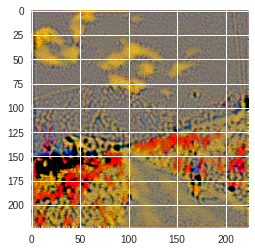

In [0]:
#  using a different image for content to see what difference does it make?
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('manonhike.jpg')

for i in range(3):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=50)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 1488.1300048828125
     Image saved. Time: 312.862774848938
Step 1
    loss: 1529.1934814453125
     Image saved. Time: 307.46683526039124


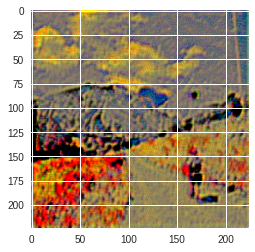

In [0]:
#  using a tiger as content image and man on hike as gen starter lets see the result 
#  the first results weren't in terms of anything it was just the man on hike image
#  trying very unsuccesfully to converge on tiger image highly inaccurate
# for the taste of convergence amping up the iterations to 10
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('manonhike.jpg')

for i in range(1):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=500)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    plt.imshow(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

In [0]:
#  using a tiger as content image and man on hike as gen starter lets see the result 
#  the first results weren't in terms of anything it was just the man on hike image
#  trying very unsuccesfully to converge on tiger image highly inaccurate
# better results would definitely come for tiger.jpg as the initialized image let's see
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('tiger.jpg')

imgs=[]
for i in range(3):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=50)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imgs.append(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 440.1596984863281
     Image saved. Time: 297.3440525531769
Step 1
    loss: 473.49249267578125
     Image saved. Time: 308.2601797580719
Step 2
    loss: 498.3694152832031
     Image saved. Time: 304.12623739242554


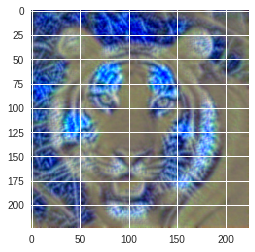

In [0]:
plt.imshow(imgs[0])


In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('pink_floyd.jpg')

imgs=[]
for i in range(3):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=5)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imgs.append(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 1306706304.0
     Image saved. Time: 1265.0073149204254
Step 1
    loss: 726931136.0
     Image saved. Time: 1149.9647171497345
Step 2
    loss: 1417187328.0
     Image saved. Time: 1267.5419714450836


In [0]:
tf.reset_default_graph()

With tf.Session as test:
  m4 = Model(inputs=model.input, outputs=model.get_layer('bn5c_branch2a').output) # this is a try towards getting layer activation
    
  a_C = m4.predict(content_image)
    
  a_G = m4.predict(generated_image)

  J_content = compute_content_cost(a_C, a_G)
  J_style = compute_style_cost(model, STYLE_LAYERS)
  J = total_cost(J_content, J_style)
  print("J = " + str(J))
  

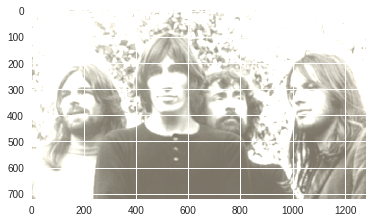

In [0]:
plt.imshow(imgs[1])

In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('pink_floyd.jpg')

imgs=[]
for i in range(5):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=5)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imgs.append(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 605118.8125
     Image saved. Time: 34.092453479766846
Step 1
    loss: 1120622.25
     Image saved. Time: 33.90357208251953
Step 2
    loss: 2751103.5
     Image saved. Time: 36.52603363990784
Step 3
    loss: 3860758.0
     Image saved. Time: 36.50644302368164
Step 4
    loss: 4384574.0
     Image saved. Time: 36.53682804107666


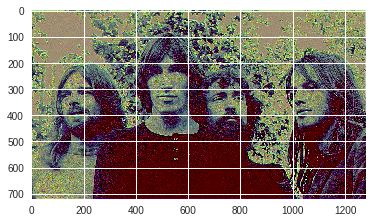

In [0]:
plt.imshow(imgs[0] )

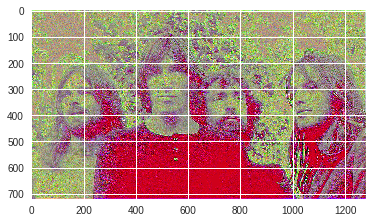

In [0]:
plt.imshow(imgs[1] )

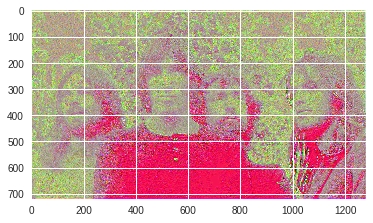

In [0]:
plt.imshow(imgs[2] )

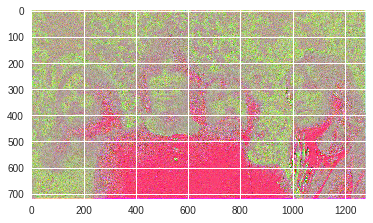

In [0]:
plt.imshow(imgs[3] )

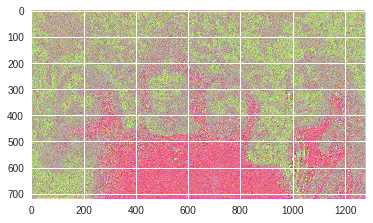

In [0]:
plt.imshow(imgs[4] )

In [0]:
evaluator = Evaluator()
K.get_session().run(tf.global_variables_initializer())

x = preprocess('pink_floyd.jpg')

imgs=[]
for i in range(15):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=5)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imgs.append(img)
#     imsave('img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Step 0
    loss: 2249710.0
     Image saved. Time: 33.97938394546509
Step 1
    loss: 8620274.0
     Image saved. Time: 36.52269458770752
Step 2
    loss: 13847735.0
     Image saved. Time: 36.54326248168945
Step 3
    loss: 16697518.0
     Image saved. Time: 36.756836891174316
Step 4
    loss: 17864370.0
     Image saved. Time: 36.581599950790405
Step 5
    loss: 18235586.0
     Image saved. Time: 36.569360971450806
Step 6
    loss: 18356690.0
     Image saved. Time: 36.51525926589966
Step 7
    loss: 18408754.0
     Image saved. Time: 36.54976749420166
Step 8
    loss: 18440802.0
     Image saved. Time: 36.57119584083557
Step 9
    loss: 18464994.0
     Image saved. Time: 36.48629570007324
Step 10
    loss: 18489506.0
     Image saved. Time: 36.5079882144928
Step 11
    loss: 18513900.0
     Image saved. Time: 36.49549078941345
Step 12
    loss: 18540946.0
     Image saved. Time: 36.54661321640015
Step 13
    loss: 18570404.0
     Image saved. Time: 36.569228172302246
Step 14
    los

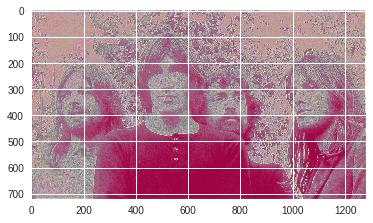

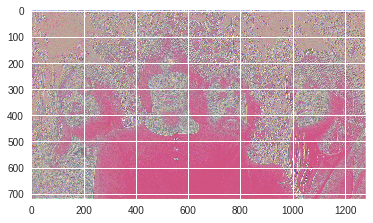

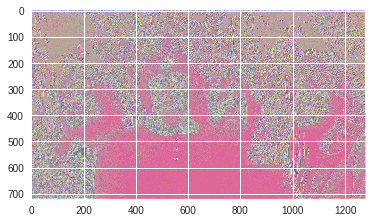

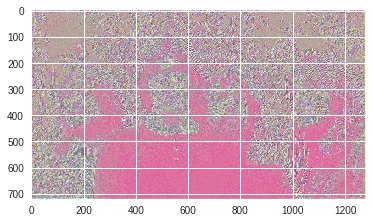

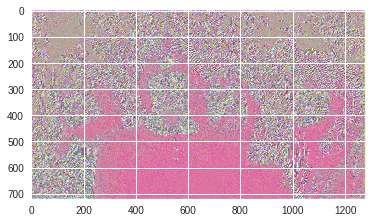

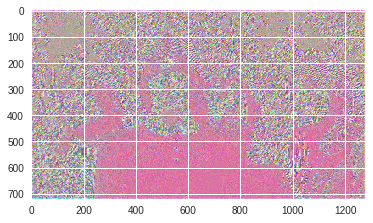

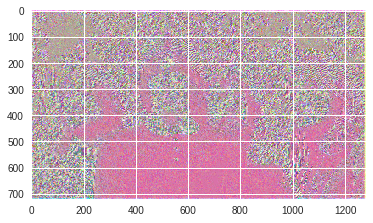

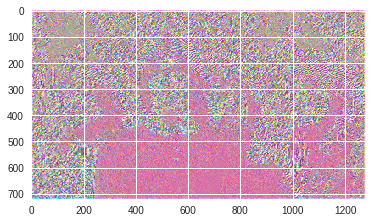

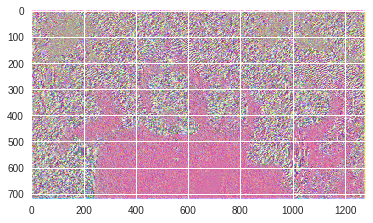

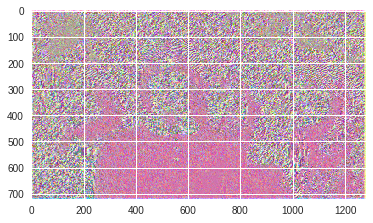

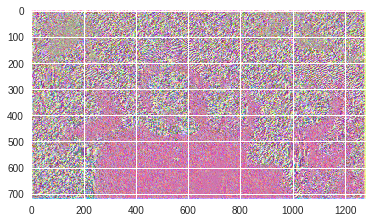

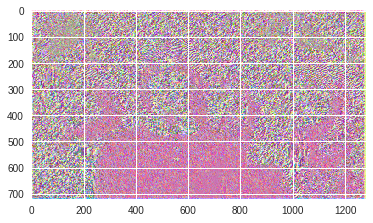

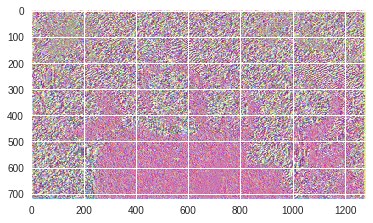

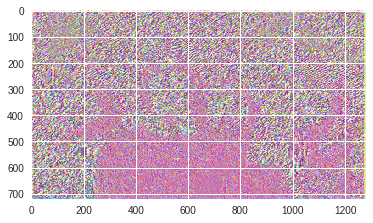

In [0]:

for i in range(15):
    plt.imshow(imgs[i])
    plt.figure(i+1)

plt.show()